In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, average_precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, validation_curve
from sklearn.model_selection import learning_curve

In [2]:
import os
print(os.listdir("./input"))

['heart.csv', 'winequality-red.csv']


In [3]:
df = pd.read_csv("./input/heart.csv")
# First 5 rows of our data
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
# set the random seed as 61 to make sure the result is repeatable
np.random.seed(61)

## Data Preprocessing

In [5]:
df.isnull().any().any() # check if there is any null value

False

In [6]:
#count of each target variable
from collections import Counter
Counter(df['target'])

Counter({1: 165, 0: 138})

<AxesSubplot:xlabel='target', ylabel='count'>

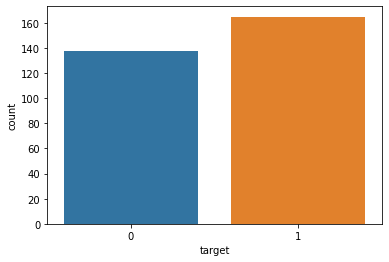

In [7]:
#check if this data is balanced
sns.countplot(x='target', data=df)

In [8]:
# drop dummy variables (cp, thal, slope)
# https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html
a = pd.get_dummies(df['cp'], prefix = "cp")
b = pd.get_dummies(df['thal'], prefix = "thal")
c = pd.get_dummies(df['slope'], prefix = "slope")
frames = [df, a, b, c]
df = pd.concat(frames, axis = 1)
df = df.drop(columns = ['cp', 'thal', 'slope'])
df.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,63,1,145,233,1,0,150,0,2.3,0,...,0,0,1,0,1,0,0,1,0,0
1,37,1,130,250,0,1,187,0,3.5,0,...,0,1,0,0,0,1,0,1,0,0
2,41,0,130,204,0,0,172,0,1.4,0,...,1,0,0,0,0,1,0,0,0,1
3,56,1,120,236,0,1,178,0,0.8,0,...,1,0,0,0,0,1,0,0,0,1
4,57,0,120,354,0,1,163,1,0.6,0,...,0,0,0,0,0,1,0,0,0,1


In [9]:
# prepare training data
y = pd.DataFrame(df.target.values, columns = ['target'])
x_data = df.drop(['target'], axis = 1)
# Normalize the data
# https://scikit-learn.org/stable/modules/preprocessing.html
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(x_data.values)
x_data_normalized = pd.DataFrame(X_train_minmax, columns = x_data.columns)
print(x_data_normalized.head(), y.head())

        age  sex  trestbps      chol  fbs  restecg   thalach  exang   oldpeak  \
0  0.708333  1.0  0.481132  0.244292  1.0      0.0  0.603053    0.0  0.370968   
1  0.166667  1.0  0.339623  0.283105  0.0      0.5  0.885496    0.0  0.564516   
2  0.250000  0.0  0.339623  0.178082  0.0      0.0  0.770992    0.0  0.225806   
3  0.562500  1.0  0.245283  0.251142  0.0      0.5  0.816794    0.0  0.129032   
4  0.583333  0.0  0.245283  0.520548  0.0      0.5  0.702290    1.0  0.096774   

    ca  ...  cp_1  cp_2  cp_3  thal_0  thal_1  thal_2  thal_3  slope_0  \
0  0.0  ...   0.0   0.0   1.0     0.0     1.0     0.0     0.0      1.0   
1  0.0  ...   0.0   1.0   0.0     0.0     0.0     1.0     0.0      1.0   
2  0.0  ...   1.0   0.0   0.0     0.0     0.0     1.0     0.0      0.0   
3  0.0  ...   1.0   0.0   0.0     0.0     0.0     1.0     0.0      0.0   
4  0.0  ...   0.0   0.0   0.0     0.0     0.0     1.0     0.0      0.0   

   slope_1  slope_2  
0      0.0      0.0  
1      0.0      0.0  
2 

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x_data_normalized,y,test_size = 0.2,random_state=0)
#transpose matrices
x_train = x_train.T
y_train = y_train.T
x_test = x_test.T
y_test = y_test.T

## Learning Curves function

In [38]:
# plot setting fix
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
matplotlib.rcParams.update({'font.size': 20})


# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5),):
    if axes is None:
        fig, axes = plt.subplots(2, 1, figsize=(15, 15))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")
    return fig, train_scores_mean[-1], test_scores_mean[-1], fit_times_mean[-1]

## Decision Tree

Decision Tree cross validate training score:  1.0
Decision Tree cross validate testing score:  0.7854591836734695
Decision Tree cross validate training time:  0.004600334167480469


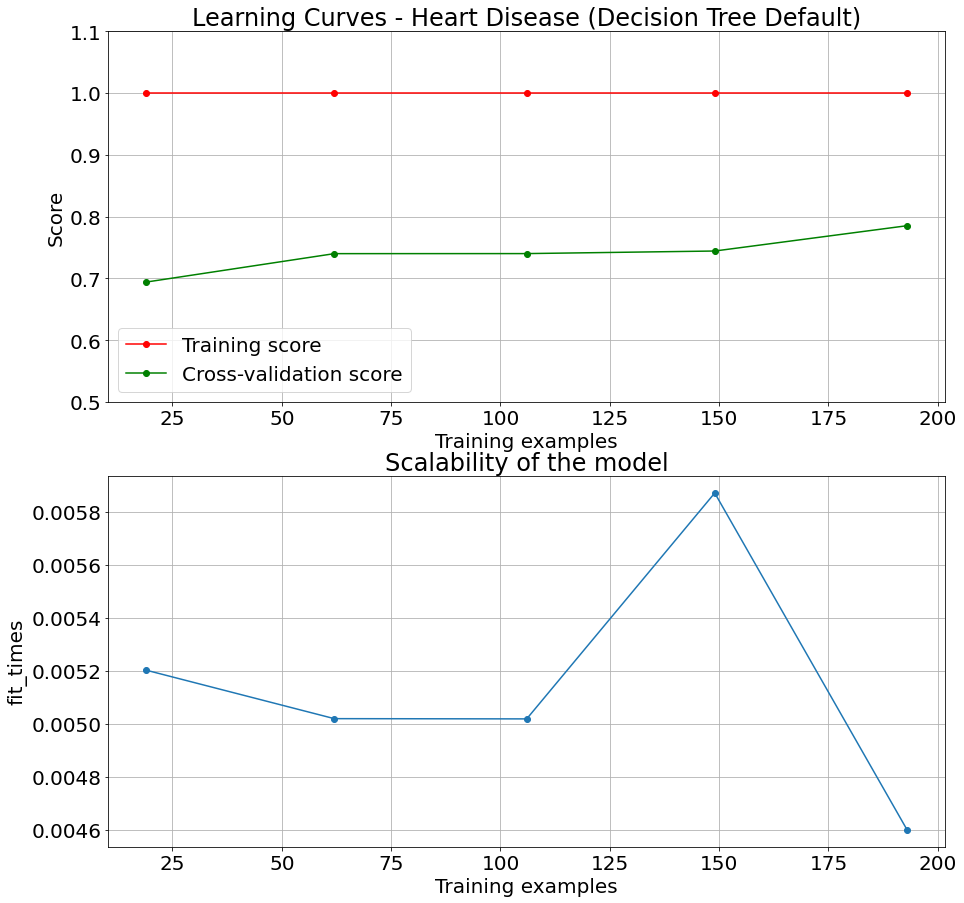

In [41]:
# Decision Tree initial setup without any optimization
from sklearn.tree import DecisionTreeClassifier
# DT learning curve plot and training time vs size
title = "Learning Curves - Heart Disease (Decision Tree Default)"
dtc = DecisionTreeClassifier()
dtc.fit(x_train.T, y_train.T)
lc_init_dt_heart, DT_training_score, DT_testing_score, DT_training_time = plot_learning_curve(dtc, title, x_train.T, y_train.T, ylim=(0.5, 1.1), n_jobs=4)
print("Decision Tree cross validate training score: ", DT_training_score)
print("Decision Tree cross validate testing score: ", DT_testing_score)
print("Decision Tree cross validate training time: ", DT_training_time)
lc_init_dt_heart.savefig("init_lc_heart_dt.png")

In [13]:
dtc_pred_test_y = dtc.predict(x_test.T)
# Calculate the score using single f1 score
dtc_test_f1_scores = f1_score(y_test.T, dtc_pred_test_y,  average="weighted") # y_true, y_predicted
print("testing f1_score", dtc_test_f1_scores)

testing f1_score 0.7872322441444048


Fitting 5 folds for each of 16 candidates, totalling 80 fits
The best DT parameters:  {'ccp_alpha': 0.01, 'max_depth': 5}
Decision Tree training score:  0.9150259067357511
Decision Tree testing score:  0.8143707482993197
Decision Tree training time:  0.005288219451904297
testing f1_score 0.852218786840759


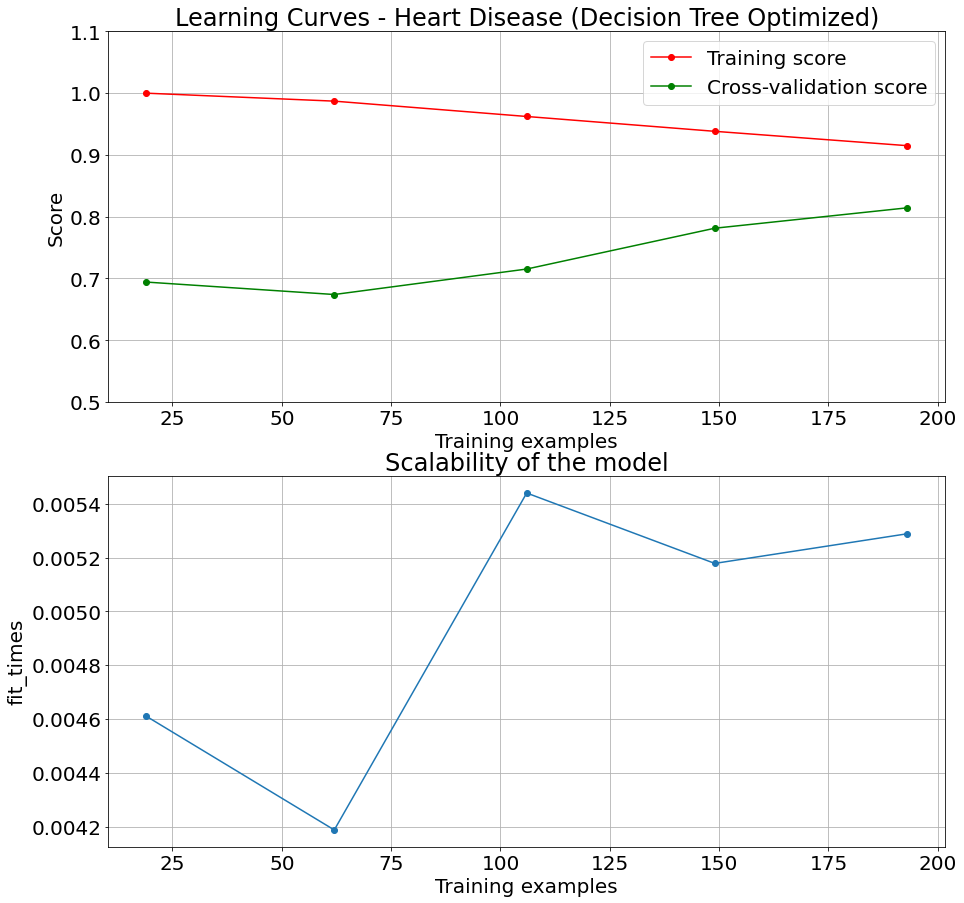

In [40]:
# Decision Tree with pruning optimized by grid search
DT_parameter_grid = {"ccp_alpha": [0.05, 0.01, 0.005, 0.001], "max_depth" : [3, 5, 10, 20]}
dtc2 = DecisionTreeClassifier()
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
dtc_opt_search = GridSearchCV(dtc2, DT_parameter_grid, scoring ='f1_weighted', n_jobs = -1, verbose = 2, return_train_score = True)
dtc_opt_search.fit(x_train.T, y_train.T)
print("The best DT parameters: ", dtc_opt_search.best_params_)
dtc_opt = dtc_opt_search.best_estimator_ # best dtc in the grid search

title = "Learning Curves - Heart Disease (Decision Tree Optimized)"

lc_dtc, DT_training_score_opt, DT_testing_score_opt, DT_training_time_opt = plot_learning_curve(dtc_opt, title, x_train.T, y_train.T, ylim=(0.5, 1.1), n_jobs=4)
print("Decision Tree training score: ", DT_training_score_opt)
print("Decision Tree testing score: ", DT_testing_score_opt)
print("Decision Tree training time: ", DT_training_time_opt)
lc_dtc.savefig("heart_dtc_lc.png") 
# f1 score metrics
dtc_pred_test_y = dtc_opt.predict(x_test.T)
# Calculate the score using single f1 score
dtc_test_f1_scores = f1_score(dtc_pred_test_y, y_test.T, average="weighted") # y_true, y_predicted
print("testing f1_score", dtc_test_f1_scores)

## KNN

KNN cross validate training score:  0.8487046632124352
KNN cross validate testing score:  0.810204081632653
KNN cross validate training time:  0.005847358703613281
knn testing f1_score 0.852936881927391


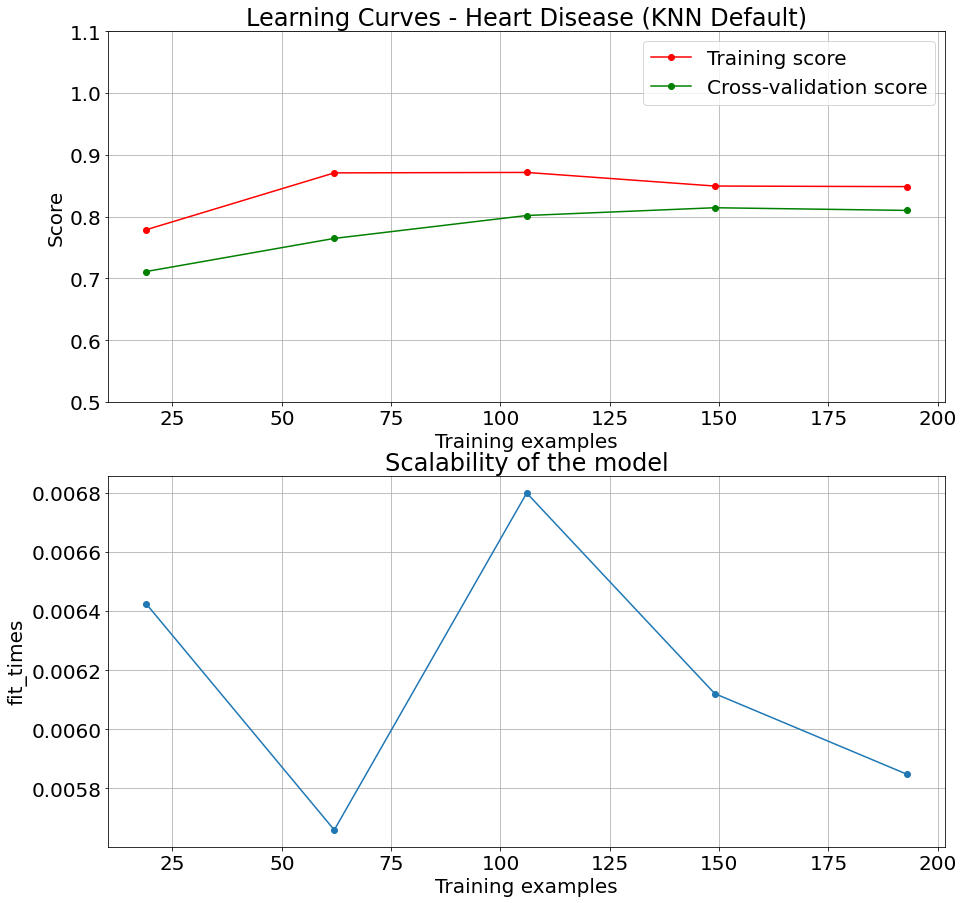

In [49]:
# KNN Model default setup
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5)  # n_neighbors means k
#print(y_train.T.shape)
knn.fit(x_train.T, y_train.T.values.ravel())
title = "Learning Curves - Heart Disease (KNN Default)"

lc_init_knn_heart, knn_training_score, knn_testing_score, knn_training_time = plot_learning_curve(knn, title, x_train.T, y_train.T, ylim=(0.5, 1.1), n_jobs=4)
print("KNN cross validate training score: ", knn_training_score)
print("KNN cross validate testing score: ", knn_testing_score)
print("KNN cross validate training time: ", knn_training_time)
lc_init_knn_heart.savefig("init_lc_heart_knn.png")

knn_pred_test_y = knn.predict(x_test.T)
# Calculate the score using single f1 score
knn_test_f1_scores = f1_score(y_test.T, knn_pred_test_y, average="weighted") # y_true, y_predicted
print("knn testing f1_score", knn_test_f1_scores)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
The best knn parameters:  {'n_neighbors': 7}
KNN training score:  0.8393782383419689
KNN testing score:  0.818452380952381
KNN training time:  0.0029419422149658202
testing f1_score 0.8854327468469871


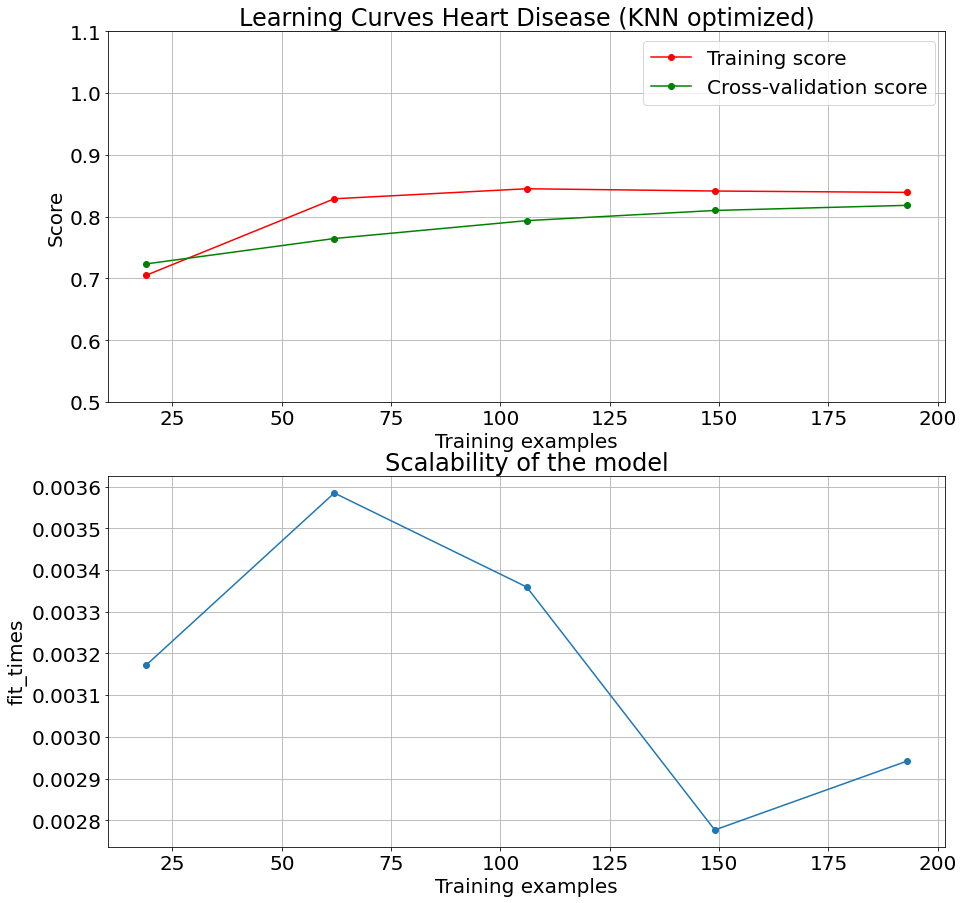

In [51]:
knn_parameter_grid = {"n_neighbors": [i for i in range(1,21)]}
knn2 = KNeighborsClassifier() 
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
knn_opt_search = GridSearchCV(knn2, knn_parameter_grid, scoring ='f1_weighted', n_jobs = -1, verbose = 2, return_train_score = True)
knn_opt_search.fit(x_train.T, y_train.T.values.ravel())
print("The best knn parameters: ", knn_opt_search.best_params_)

# KNN learning curve
title = "Learning Curves Heart Disease (KNN optimized)"
knn_opt = knn_opt_search.best_estimator_ # best knn in the grid search
lc_knn, KNN_training_score_opt, KNN_testing_score_opt, KNN_training_time_opt = plot_learning_curve(knn_opt, title, x_train.T, y_train.T.values.ravel(), ylim=(0.5, 1.1), n_jobs=4)
print("KNN training score: ", KNN_training_score_opt)
print("KNN testing score: ", KNN_testing_score_opt)
print("KNN training time: ", KNN_training_time_opt)
lc_knn.savefig("heart_knn_lc.png") 

# f1 score metrics
knn_pred_test_y = knn_opt.predict(x_test.T)
# Calculate the score using single f1 score
knn_test_f1_scores = f1_score(y_test.T, knn_pred_test_y, average="weighted") # y_true, y_predicted
print("testing f1_score", knn_test_f1_scores)

## Support Vector Machine

SVM cross validate training score:  0.8797927461139896
SVM cross validate testing score:  0.8226190476190476
SVM cross validate training time:  0.006172704696655274
svm testing f1_score 0.8849948672431492


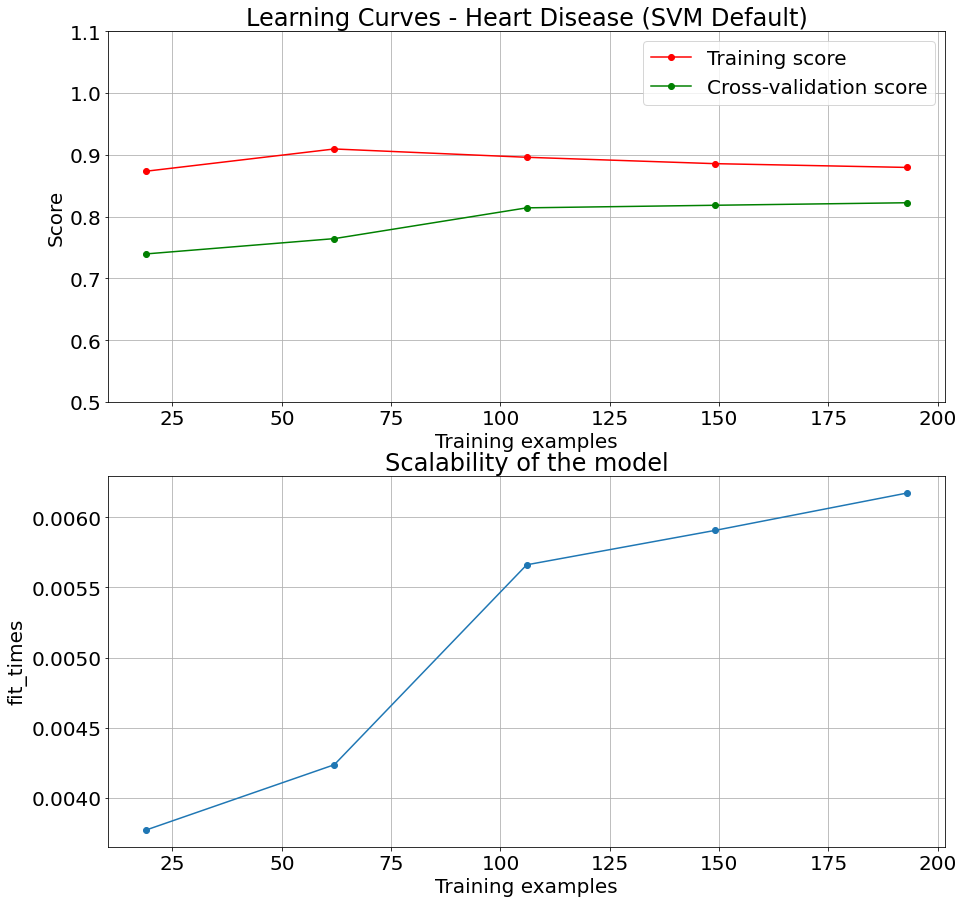

In [54]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(x_train.T, y_train.T.values.ravel())
title = "Learning Curves - Heart Disease (SVM Default)"
lc_init_svm_heart, svm_training_score, svm_testing_score, svm_training_time = plot_learning_curve(svm, title, x_train.T, y_train.T, ylim=(0.5, 1.1), n_jobs=4)
print("SVM cross validate training score: ", svm_training_score)
print("SVM cross validate testing score: ", svm_testing_score)
print("SVM cross validate training time: ", svm_training_time)
lc_init_svm_heart.savefig("init_lc_heart_svm.png")

svm_pred_test_y = svm.predict(x_test.T)
# Calculate the score using single f1 score
svm_test_f1_scores = f1_score(y_test.T, svm_pred_test_y, average="weighted") # y_true, y_predicted
print("svm testing f1_score", svm_test_f1_scores)

In [62]:
# find the optimal kernel and regulation parameter C
SVM_param_grid = {
    'kernel': ["linear", "poly", "rbf", "sigmoid"],
    'C' : [0.1, 0.5, 1.0, 2.0]
}

svm2 = SVC()
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
svm_opt_search = GridSearchCV(svm2, SVM_param_grid, scoring ='f1_weighted', n_jobs = -1, verbose = 2, return_train_score = True)
svm_opt_search.fit(x_train.T, y_train.T.values.ravel())
print("The best SVM parameters: ", svm_opt_search.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
The best SVM parameters:  {'C': 0.1, 'kernel': 'poly'}


SVM training score:  0.8569948186528495
SVM testing score:  0.8308673469387756
SVM training time:  0.004317188262939453
testing f1_score 0.8512366387330735


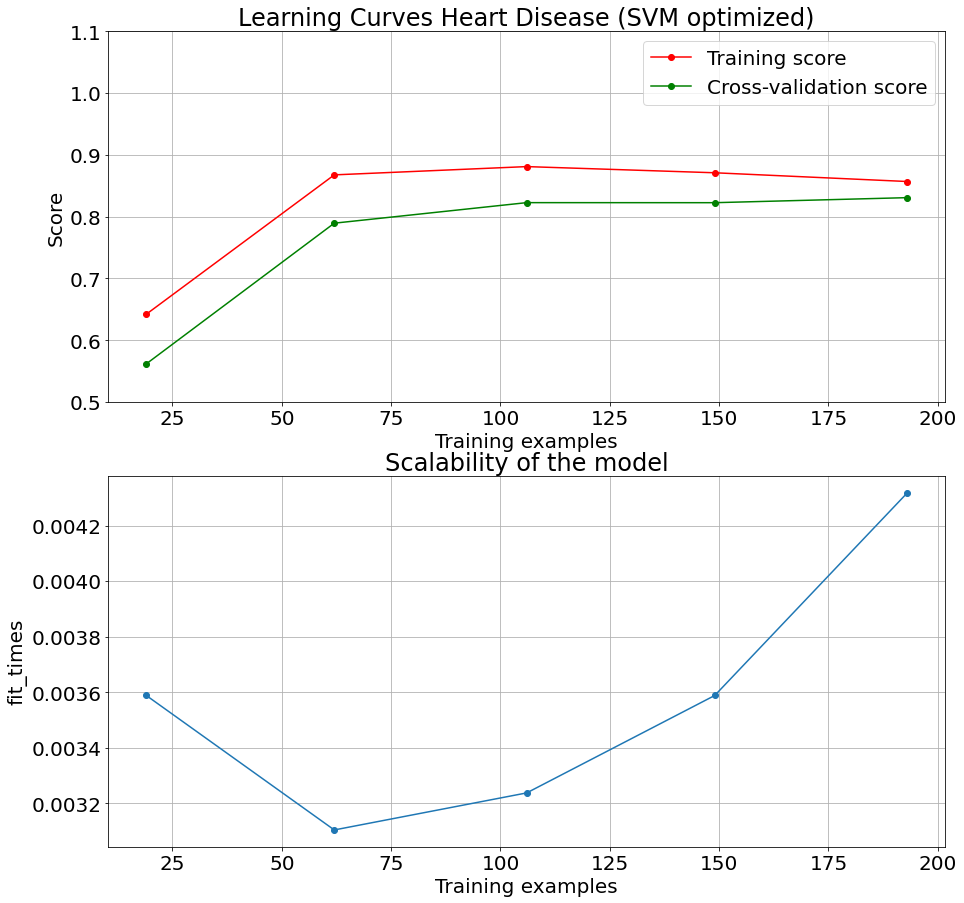

In [63]:
# learning curve on optimized support vector machine
title = "Learning Curves Heart Disease (SVM optimized)"
svm_opt = svm_opt_search.best_estimator_ # best SVM in the grid search
lc_svm, SVM_training_score_opt, SVM_testing_score_opt, SVM_training_time_opt = plot_learning_curve(svm_opt, title, x_train.T, y_train.T.values.ravel(), ylim=(0.5, 1.1), n_jobs=4)
print("SVM training score: ", SVM_training_score_opt)
print("SVM testing score: ", SVM_testing_score_opt)
print("SVM training time: ", SVM_training_time_opt)
lc_svm.savefig("heart_svm_lc.png") 

# f1 score metrics
svm_pred_test_y = svm_opt.predict(x_test.T)
# Calculate the score using single f1 score
svm_test_f1_scores = f1_score(y_test.T, svm_pred_test_y, average="weighted") # y_true, y_predicted
print("testing f1_score", svm_test_f1_scores)

## Adaboost

Adaboost cross validate training score:  1.0
Adaboost cross validate testing score:  0.7649659863945578
Adaboost cross validate training time:  0.005307292938232422
ada testing f1_score 0.7711127670144063


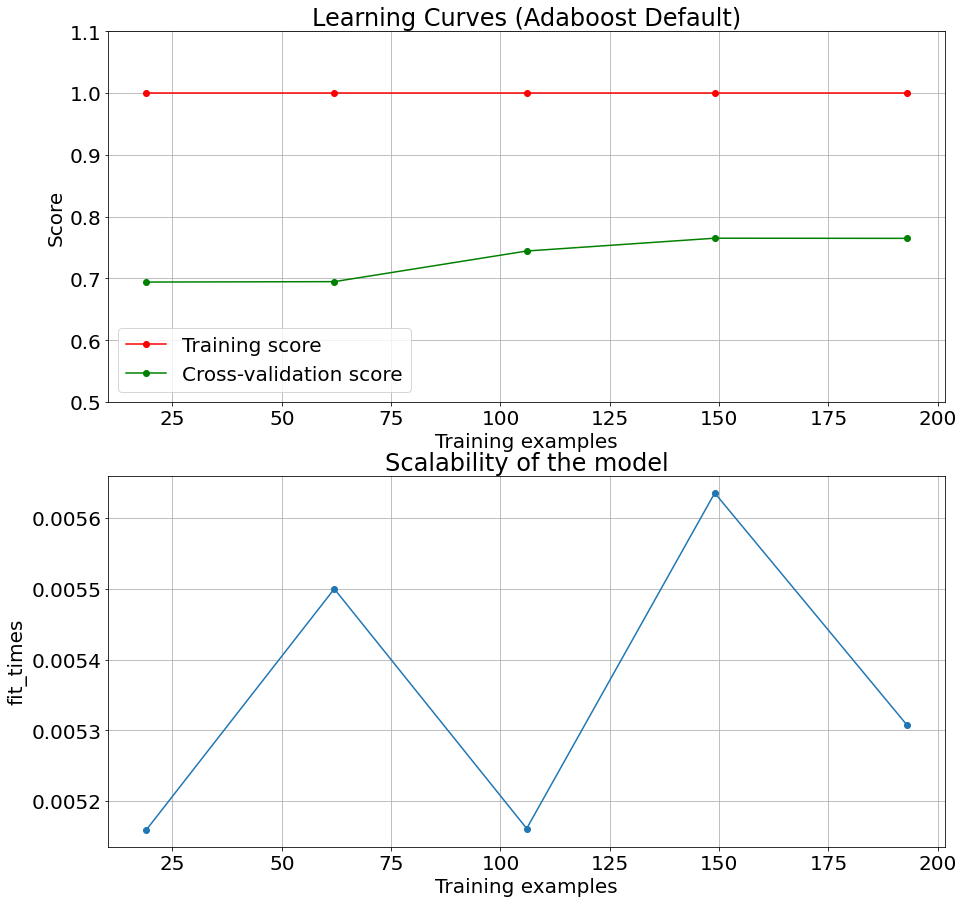

In [42]:
# Ada boost based on decision tree
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
from sklearn.ensemble import AdaBoostClassifier
dt_base = DecisionTreeClassifier()
ada = AdaBoostClassifier(base_estimator = dt_base, n_estimators = 50, learning_rate = 0.05)
ada.fit(x_train.T, y_train.T.values.ravel())

title = "Learning Curves (Adaboost Default)"
lc_init_ada_heart, ada_training_score, ada_testing_score, ada_training_time = plot_learning_curve(ada, title, x_train.T, y_train.T, ylim=(0.5, 1.1), n_jobs=4)
print("Adaboost cross validate training score: ", ada_training_score)
print("Adaboost cross validate testing score: ", ada_testing_score)
print("Adaboost cross validate training time: ", ada_training_time)
lc_init_ada_heart.savefig("init_lc_heart_ada.png")

ada_pred_test_y = ada.predict(x_test.T)
# Calculate the score using single f1 score
ada_test_f1_scores = f1_score(y_test.T, ada_pred_test_y, average="weighted") # y_true, y_predicted
print("ada testing f1_score", ada_test_f1_scores)


In [21]:
# find the optimal adaboost
adaboost_param_grid = {
    'n_estimators': [25, 50, 75, 100],
    'learning_rate' : [10, 1, 0.1, 0.01, 0.001],
    'base_estimator__max_depth': [3, 5, 10, 20],
    "base_estimator__ccp_alpha": [0.05, 0.01, 0.005, 0.001]
}
dt_base2 = DecisionTreeClassifier()
ada2 = AdaBoostClassifier(base_estimator = dt_base2)
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
ada_opt_search = GridSearchCV(ada2, adaboost_param_grid, scoring ='f1_weighted', n_jobs = -1, verbose = 2, return_train_score = True)
ada_opt_search.fit(x_train.T, y_train.T.values.ravel())
print("The best adaboost parameters: ", ada_opt_search.best_params_)


Fitting 5 folds for each of 320 candidates, totalling 1600 fits
The best adaboost parameters:  {'base_estimator__ccp_alpha': 0.05, 'base_estimator__max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 25}


adaboost training score:  0.8632124352331607
adaboost testing score:  0.8389455782312926
adaboost training time:  0.04995617866516113
ada testing f1_score 0.8526992459461262


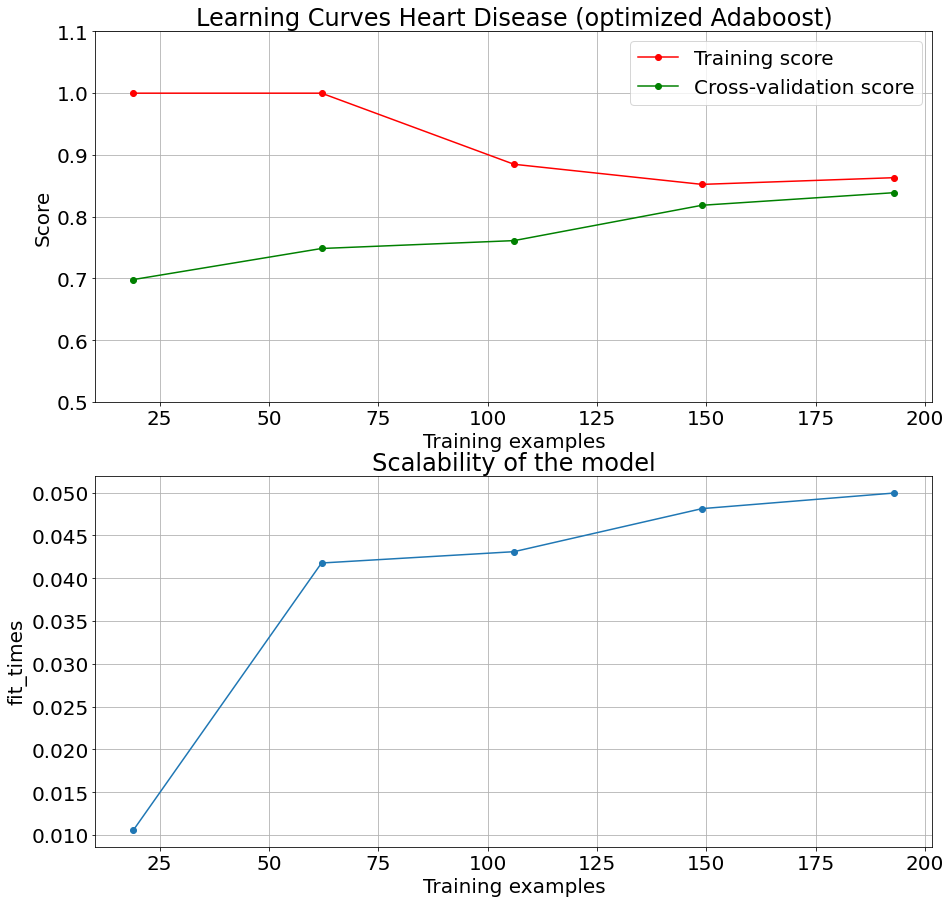

In [44]:
title = "Learning Curves Heart Disease (optimized Adaboost)"
ada_opt = ada_opt_search.best_estimator_ # best adaboost in the grid search
lc_ada, ada_training_score_opt, ada_testing_score_opt, ada_training_time_opt = plot_learning_curve(ada_opt, title, x_train.T, y_train.T.values.ravel(), ylim=(0.5, 1.1), n_jobs=4)
print("adaboost training score: ", ada_training_score_opt)
print("adaboost testing score: ", ada_testing_score_opt)
print("adaboost training time: ", ada_training_time_opt)
lc_ada.savefig("heart_ada_lc.png") 
ada_pred_test_y = ada_opt.predict(x_test.T)
# Calculate the score using single f1 score
ada_test_f1_scores = f1_score(y_test.T, ada_pred_test_y, average="weighted") # y_true, y_predicted
print("ada testing f1_score", ada_test_f1_scores)

## Neural Network

Neural Network training score:  0.882901554404145
Neural Network testing score:  0.8224489795918368
Neural Network training time:  0.23620524406433105
nn testing f1_score 0.8688524590163934


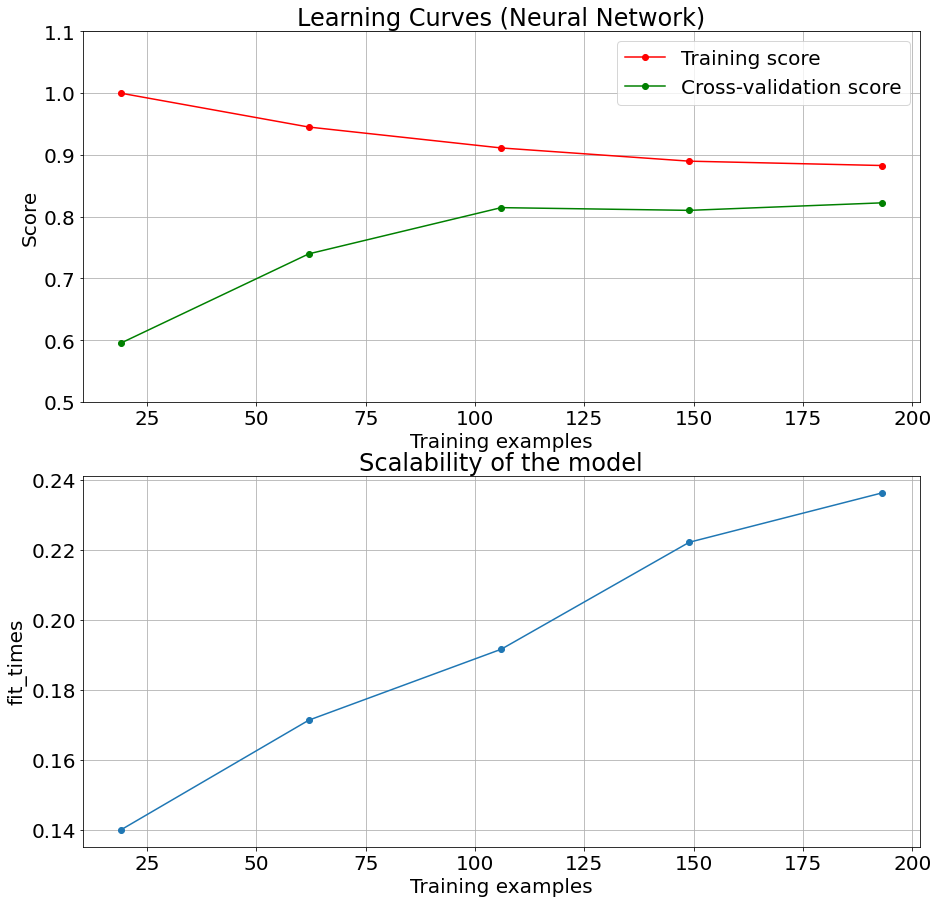

In [46]:
from sklearn.neural_network import MLPClassifier
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
#https://scikit-learn.org/stable/modules/neural_networks_supervised.html#classification
nn = MLPClassifier()
title = "Learning Curves (Neural Network)"
nn.fit(x_train.T, y_train.T.values.ravel())

lc_init_nn_heart, nn_training_score, nn_testing_score, nn_training_time = plot_learning_curve(nn, title, x_train.T, y_train.T.values.ravel(), ylim=(0.5, 1.1), n_jobs=4)
print("Neural Network training score: ", nn_training_score)
print("Neural Network testing score: ", nn_testing_score)
print("Neural Network training time: ", nn_training_time)
lc_init_nn_heart.savefig("init_lc_heart_nn.png")

nn_pred_test_y = nn.predict(x_test.T)
# Calculate the score using single f1 score
nn_test_f1_scores = f1_score(y_test.T, nn_pred_test_y, average="weighted") # y_true, y_predicted
print("nn testing f1_score", nn_test_f1_scores)

In [47]:
nn_param_grid = {
    'hidden_layer_sizes': [(100), (10,50), (10,50,80), (10, 50, 80, 120)],
    'learning_rate_init': [1, 0.1, 0.01, 0.001]
}
nn2 = MLPClassifier()
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
nn_opt_search = GridSearchCV(nn2, nn_param_grid, scoring ='f1_weighted', n_jobs = -1, verbose = 2, return_train_score = True)
nn_opt_search.fit(x_train.T, y_train.T.values.ravel())
print("The best nn parameters: ", nn_opt_search.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
The best nn parameters:  {'hidden_layer_sizes': 100, 'learning_rate_init': 0.001}


Neural Network training score:  0.8808290155440414
Neural Network testing score:  0.8267006802721089
Neural Network training time:  0.2407754898071289
nn testing f1_score 0.8842951634590572


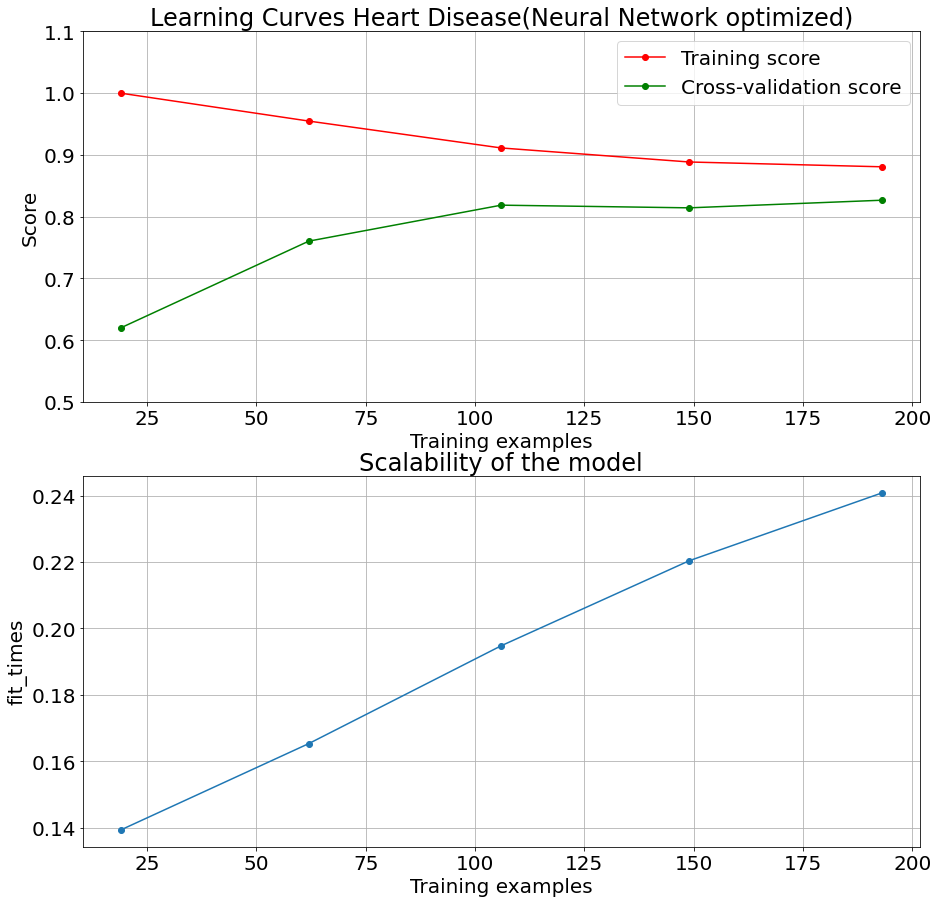

In [48]:
nn_opt = nn_opt_search.best_estimator_ # best adaboost in the grid search
title = "Learning Curves Heart Disease(Neural Network optimized)"
lc_nn, nn_training_score_opt, nn_testing_score_opt, nn_training_time_opt = plot_learning_curve(nn_opt, title, x_train.T, y_train.T.values.ravel(), ylim=(0.5, 1.1), n_jobs=4)
print("Neural Network training score: ", nn_training_score_opt)
print("Neural Network testing score: ", nn_testing_score_opt)
print("Neural Network training time: ", nn_training_time_opt)
lc_nn.savefig("heart_nn_lc.png") 
nn_pred_test_y = nn_opt.predict(x_test.T)
# Calculate the score using single f1 score
nn_test_f1_scores = f1_score(y_test.T, nn_pred_test_y, average="weighted") # y_true, y_predicted
print("nn testing f1_score", nn_test_f1_scores)
